In [1]:
import numpy as np
import cv2
import os
import glob
import torch
from density import PDM, Delta
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import pickle
from tqdm import tqdm
bim_floor = cv2.imread("/home/gaobiaoli/dataset/base/target8F_L.png")
gt_path="/home/gaobiaoli/dataset/result/gt/D06_20210318083729"
mask_path="/home/gaobiaoli/dataset/base/mask-r"
H = np.load("/home/gaobiaoli/dataset/base/8F_D06.npy")
def cal_single_gt(gt_path,mask,H):
    gt_list=glob.glob(gt_path+"/*.png")
    gt_dict={}
    A_mask=np.sum(mask>0)
    for i in range(len(gt_list)):
        gt_r=cv2.imread(gt_list[i],0)
        gt = cv2.warpPerspective(
                gt_r, H, mask.shape[::-1], borderValue=0
            )
        A_gt=np.sum(gt*(mask>0)>0)
        gt_dict[int(os.path.basename(gt_list[i]).split(".")[0])]=A_gt/A_mask
    prev_value = None
    gt_x=[]
    gt_y=[]
    for key in sorted(gt_dict.keys()):
        if prev_value is not None and gt_dict[key] < prev_value:
            gt_dict[key] = prev_value
        prev_value = gt_dict[key]
        gt_x.append(key)
        gt_y.append(gt_dict[key])
    return gt_dict,[gt_x,gt_y]
def cal_single_pred(mask_list,flag_map):
    percentage_list=[]
    for mask in mask_list:
        A_mask=np.sum(mask>0)
        A_pred=np.sum(flag_map*(mask>0)>0)
        percentage_list.append(A_pred/A_mask)
    return percentage_list
gt_list=[]
mask_list=[]
for mask_id in range(1,11):
    if mask_id==9:
        continue
    mask=cv2.imread(os.path.join(mask_path,f"{mask_id}.png"),0)
    gt_dict,gt_xy=cal_single_gt(gt_path=gt_path,mask=mask,H=H)
    gt_list.append(gt_xy[1])
    mask_list.append(mask)
all_mask = np.sum(mask_list, axis=0)>0
label_index=gt_xy[0]


In [26]:
Progress_I=[]

In [37]:
#设置检测间隔
results_path="./result/D06_20210318083729_i10_4.pth"
results_raw=torch.load(results_path)
frame_interval=500
label_interval=5000
result_interval = int(frame_interval/10)
results=results_raw[result_interval-1::result_interval]
#key frame
gamma_list=[0.8,0.9,1.0,1.1,1.2]
Progress_T=[]
interval=int(label_interval/frame_interval)
ids=range(0,len(results),interval)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
density=np.zeros(bim_floor.shape[:2],dtype=np.float32)
pdm=PDM(density,alpha=gamma_list[0],frame_interval=frame_interval,T_need=25)
interval=int(label_interval/frame_interval)
ids=list(range(0,len(results),interval))+[len(results)]
for i in tqdm(range(len(ids)-1)):
    delta.add_points_list(results[ids[i]:ids[i+1]])
    pdm.update_map(delta.get_raw(masked=True,process=False))
    progress_gamma=[]
    for gamma in gamma_list:
        pdm.set_alpha(alpha=gamma)
        flag_map=pdm.get_flag()
        progress_mask=cal_single_pred(mask_list,flag_map)
        progress_gamma.append(progress_mask)
    Progress_T.append(progress_gamma)
Progress_I.append(Progress_T)

100%|██████████| 22/22 [00:34<00:00,  1.59s/it]


/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


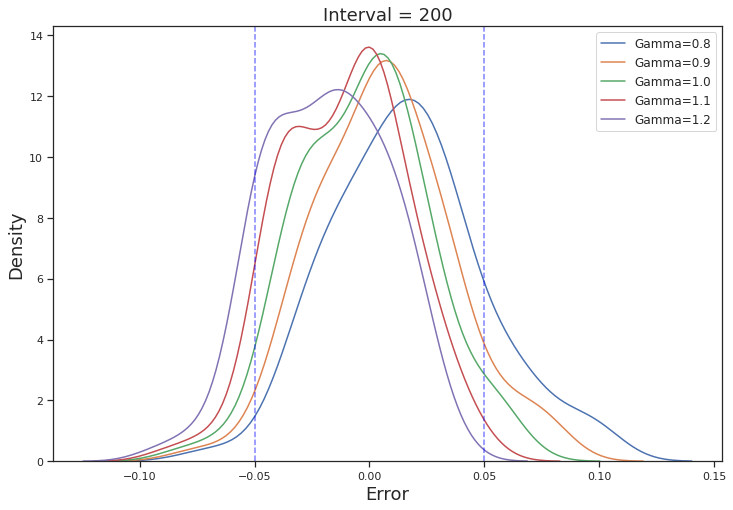

In [46]:
frame_interval=200
Progress_T=Progress_I[2]
MAE_gamma=[[] for _ in range(len(gamma_list))]
MRE_gamma=[[] for _ in range(len(gamma_list))]
for gamma_i in range(len(gamma_list)):
    for t_i in range((len(label_index))):
        for mask_i in range(len(mask_list)):
            pred=Progress_T[t_i][gamma_i][mask_i]
            gt=gt_list[mask_i][t_i]
            # if gt-0.05 >= 0 and gt <= 0.95:
            MAE_gamma[gamma_i].append(pred - gt)
            MRE_gamma[gamma_i].append((pred - gt)/gt)
plt.figure(figsize=(12, 8))
for i in range(len(gamma_list)):
    data=list(set(MAE_gamma[i]))
    sns.kdeplot(data=data, label=f'Gamma={gamma_list[i]}')

plt.axvline(x=0.05, linestyle='--', color='blue',alpha=0.5)
plt.axvline(x=-0.05, linestyle='--', color='blue',alpha=0.5)
# 添加图标题和坐标轴标签
plt.legend(fontsize=12)
plt.title(f'Interval = {frame_interval}',fontsize=18)
plt.xlabel('Error' ,fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.savefig(f"{frame_interval}.png",dpi=1000)



/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Error')

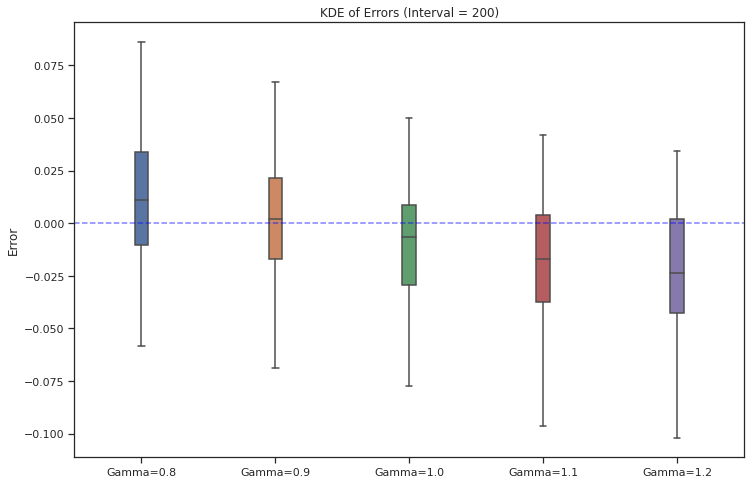

In [36]:
Progress_T=Progress_I[1]
MAE_gamma=[[] for _ in range(len(gamma_list))]
MRE_gamma=[[] for _ in range(len(gamma_list))]
for gamma_i in range(len(gamma_list)):
    for t_i in range((len(label_index))):
        for mask_i in range(len(mask_list)):
            pred=Progress_T[t_i][gamma_i][mask_i]
            gt=gt_list[mask_i][t_i]
            # if gt-0.05 >= 0 and gt <= 0.95:
            MAE_gamma[gamma_i].append(pred - gt)
            MRE_gamma[gamma_i].append((pred - gt)/gt)
plt.figure(figsize=(12, 8))
sns.set(style="ticks")
for i in range(len(gamma_list)):
    MAE_gamma[i]=list(set(MAE_gamma[i]))
sns.boxplot(data=MAE_gamma,showfliers=False,width=0.1)
plt.axhline(y=0.00, linestyle='--', color='blue',alpha=0.5)
# plt.axhline(x=-0.05, linestyle='--', color='blue',alpha=0.5)
# 添加图标题和坐标轴标签
plt.title(f'KDE of Errors (Interval = {frame_interval})')
plt.xticks(ticks=range(len(gamma_list)), labels=[f'Gamma={gamma}' for gamma in gamma_list])
# plt.xlabel('Gamma')
plt.ylabel('Error')



In [13]:
len(Progress_I[0])

22

/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


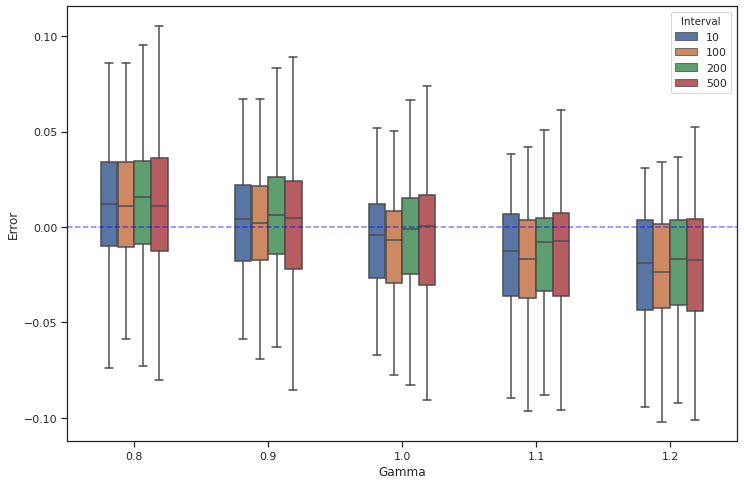

In [38]:
import pandas as pd


plt.figure(figsize=(12, 8))


interval_list=[10,100,200,500]
data=[]
for interval,Progress_T in zip(interval_list,Progress_I):
    MAE_gamma=[[] for _ in range(len(gamma_list))]
    MRE_gamma=[[] for _ in range(len(gamma_list))]
    for gamma_i in range(len(gamma_list)):
        for t_i in range((len(label_index))):
            for mask_i in range(len(mask_list)):
                pred=Progress_T[t_i][gamma_i][mask_i]
                gt=gt_list[mask_i][t_i]
                # if gt-0.05 >= 0 and gt <= 0.95:
                MAE_gamma[gamma_i].append(pred - gt)
                MRE_gamma[gamma_i].append((pred - gt)/gt)
        MAE_gamma[gamma_i]=list(set(MAE_gamma[gamma_i]))
        for error in MAE_gamma[gamma_i]:
            data.append({'Gamma': gamma_list[gamma_i], 'Error': error, 'Interval': interval})




# for i, error_interval in enumerate(Progress_I):
#     interval = interval_list[i]
#     for j, error_gamma in enumerate(error_interval):
#         for error_value in error_gamma:
#             data.append({'Gamma': gamma_list[j], 'Error': error_value, 'Interval': interval})
df = pd.DataFrame(data)

# # 使用 seaborn 绘制并排的箱型图
sns.boxplot(x='Gamma', y='Error', hue='Interval', data=df,showfliers=False,width=0.5)
plt.axhline(y=0.00, linestyle='--', color='blue',alpha=0.5)

# # 添加图标题和坐标轴标签
# plt.title('Boxplot of Errors for Different Gamma Values and Intervals')
# plt.xlabel('Gamma')
# plt.ylabel('Error')

# # 显示图形
# plt.show()

/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


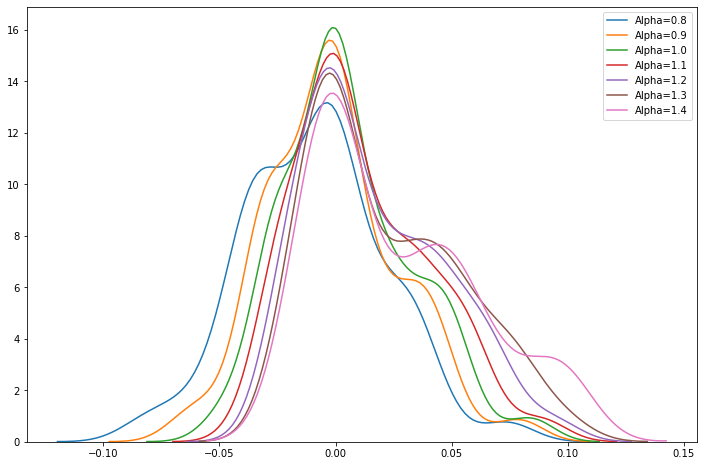

In [ ]:
import seaborn as sns
# data = [x for sublist in MAE for x in sublist]
# sns.kdeplot(data=data, hue=gamma_list, palette='viridis', shade=True)
plt.figure(figsize=(12, 8))
for i in range(len(gamma_list)):
    sns.kdeplot(data=MAE[i], label=f'Alpha={gamma_list[i]}')

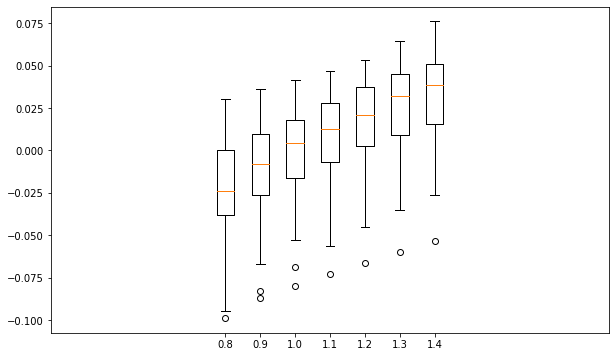

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(MAE, positions=gamma_list, widths=0.05)
plt.show()

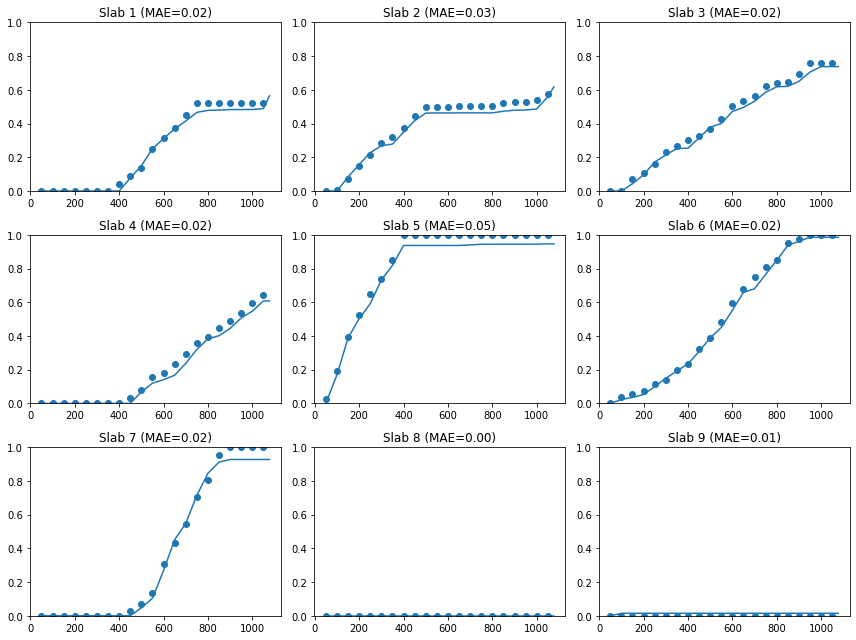

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 子图的行数和列数
rows = 3
cols = 3

# 每个子图的大小
subplot_width = 4
subplot_height = 3

# 计算整张图的大小
fig_width = cols * subplot_width
fig_height = rows * subplot_height

# 创建一个包含多个子图的图像，并设置大小
fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

# 通过循环在每个子图中绘制内容
# x=[i for i in range(50,len(results)+50,50)]
for i in range(len(mask_list)):
    row = i // cols
    col = i % cols
    y = [pred[i] for pred in progress]
    axs[row, col].plot(x, y)
    sc_x=[i/100 for i in gt_list[i].keys()]
    sc_y=list(gt_list[i].values())

    # eval
    mae=0
    mre=0
    count=0
    for si in range(len(sc_x)):
        gt=sc_y[si]
        pred=y[x.index(sc_x[si])]
        mae += abs(gt - pred)
        if gt != 0:
            mre += abs((gt - pred) / gt)
            count += 1
    mae /= len(sc_x)
    mre /= count if count > 0 else 1 
    
    axs[row, col].scatter(sc_x,sc_y)
    axs[row, col].set_ylim([0, 1])
    axs[row, col].set_title(f"Slab {i+1} (MAE={mae:.2f})")
plt.tight_layout()
plt.show()
# plt.savefig("/home/gaobiaoli/dataset/result/heat_map/progress.png",dpi=1000)
